In [22]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from alive_progress import alive_bar
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import math
import numpy as np
from IPython.display import display, Image
import io
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from scikeras.wrappers import KerasClassifier

In [54]:
features = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']
df = None
X,Y = [],[]
with alive_bar(force_tty=True) as bar: 
    for file in (os.listdir('../Fall')):
        file_path = f'../Fall/{file}'
        df = pd.read_csv(file_path,usecols=features)
        df = df.reindex(range(1000), fill_value=0)
        X.append(tf.convert_to_tensor(df))
        Y.append(1)
        bar()
df = None
with alive_bar(force_tty=True) as bar:
    for file in os.listdir('../Not Fall'):
        file_path = f'../Not Fall/{file}'
        df = pd.read_csv(file_path,usecols=features)
        df = df.reindex(range(1000), fill_value=0)
        X.append(tf.convert_to_tensor(df))
        Y.append(0)
        bar()

del df

|████████████████████████████████████████| 2306 in 15.7s (146.91/s)             
|████████████████████████████████████████| 2253 in 12.5s (180.09/s)             


In [55]:
X_tensor = np.asarray(X)
y_tensor = np.asarray(Y)

INPUT_DIM = 9
OUTPUT_DIM = 1
SEQUENCE_LEN = 1000
loss="binary_crossentropy"
optimizer="adam"
metrics=['accuracy']
early_stopping_monitor = EarlyStopping(
    monitor='accuracy',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)


X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.10, random_state=42)
# X_val,X_test,y_val,y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
batch_size = 16
epochs = 20

In [56]:
def get_model_layers_str(model):
    # Abbreviations for common layer types, including LSTM and RNN
    abbreviations = {
        'Conv2D': 'C',
        'Flatten': 'F',
        'Dense': 'D',
        'MaxPooling2D': 'MP',
        'AveragePooling2D': 'AP',
        'LSTM': 'L',
        'SimpleRNN': 'R',
        # Add more abbreviations as needed
    }

    layer_names = []
    for layer in model.layers:
        name = layer.__class__.__name__
        # Checking if the layer has a 'units' attribute (like in Dense, LSTM, RNN layers)
        if hasattr(layer, 'units'):
            name = f'{abbreviations.get(name, name)}{layer.units}'
        # Checking if the layer has a 'filters' attribute (like in Conv2D layers)
        elif hasattr(layer, 'filters'):
            name = f'{abbreviations.get(name, name)}{layer.filters}'
        else:
            name = abbreviations.get(name, name)
        layer_names.append(name)

    return "_".join(layer_names)

In [71]:
# Model
def getmodel():
    model = keras.Sequential()
    model.add(layers.LSTM(64,input_dim=INPUT_DIM,input_length=SEQUENCE_LEN,return_sequences=True))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(16,activation="relu"))
    model.add(layers.Dense(OUTPUT_DIM,activation="sigmoid"))
    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
    return model

In [75]:
model=getmodel()
batch_size=batch_size
epochs=20
model_name=None

if(model_name==None):
    model_name = f"model_l{len(model.layers)}_{get_model_layers_str(model)}_b{batch_size}_e{epochs}_p{X_train.shape[-1]}"
history_name = f"history_{model_name}"
print(model_name)

model_l4_L64_L32_D16_D1_b16_e20_p9


Split 0
Epoch 1/10
231/231 [==============================] - 29s 98ms/step - loss: 0.5762 - accuracy: 0.6617
Epoch 2/10
231/231 [==============================] - 22s 97ms/step - loss: 0.3799 - accuracy: 0.8207
Epoch 3/10
231/231 [==============================] - 23s 98ms/step - loss: 0.3792 - accuracy: 0.8275
Epoch 4/10
231/231 [==============================] - 23s 98ms/step - loss: 0.5917 - accuracy: 0.6972
Epoch 5/10
231/231 [==============================] - 23s 99ms/step - loss: 0.6407 - accuracy: 0.6289
Epoch 6/10
231/231 [==============================] - 23s 100ms/step - loss: 0.5806 - accuracy: 0.6677
Epoch 7/10
231/231 [==============================] - 22s 97ms/step - loss: 0.5127 - accuracy: 0.6937
Epoch 8/10
231/231 [==============================] - 23s 98ms/step - loss: 0.3075 - accuracy: 0.8968
Epoch 9/10
231/231 [==============================] - 22s 97ms/step - loss: 0.2263 - accuracy: 0.9280
Epoch 10/10
231/231 [==============================] - 22s 97ms/step - lo

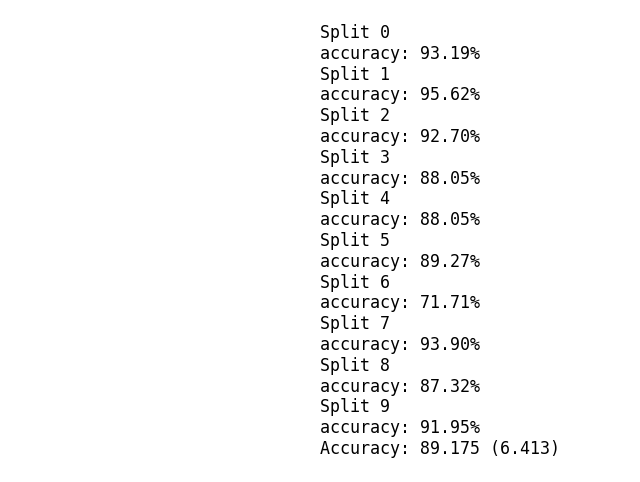

In [77]:
# Cross validate
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cvscores = []
cross_val_report = ""
for index,( train, test) in enumerate(kfold.split(X_train, y_train)):
    model = getmodel()
    print(f"Split {index}")
    cross_val_report+=f"Split {index}\n"
    model.fit(X_tensor[train], y_tensor[train], epochs=10, batch_size=batch_size
              , verbose=1)    
    scores = model.evaluate(X_tensor[test], y_tensor[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cross_val_report+="%s: %.2f%%\n" % (model.metrics_names[1], scores[1]*100)

    cvscores.append(scores[1] * 100)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(cvscores), std(cvscores)))
cross_val_report+='Accuracy: %.3f (%.3f)' % (mean(cvscores), std(cvscores))


fig, ax = plt.subplots(figsize=(8, 6)) # Adjust the size as needed
ax.text(0.5, 0.5, cross_val_report, horizontalalignment='left', verticalalignment='center', 
        fontsize=12, family='monospace', transform=ax.transAxes)
ax.axis('off')

# Save to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

# Display the image in the notebook
display(Image(buf.getvalue()))

# Optionally, write to a file
with open(f'{model_name}_cross_val.png', 'wb') as f:
    f.write(buf.getvalue())

plt.close(fig)

In [79]:
# Train
model = getmodel()
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=True,callbacks=[early_stopping_monitor])

Epoch 1/20
257/257 [==============================] - 29s 100ms/step - loss: 0.6109 - accuracy: 0.5964
Epoch 2/20
257/257 [==============================] - 26s 100ms/step - loss: 0.4876 - accuracy: 0.7670
Epoch 3/20
257/257 [==============================] - 26s 100ms/step - loss: 0.4905 - accuracy: 0.8031
Epoch 4/20
257/257 [==============================] - 26s 100ms/step - loss: 0.5012 - accuracy: 0.7889
Epoch 5/20
257/257 [==============================] - 26s 100ms/step - loss: 0.5227 - accuracy: 0.7736
Epoch 6/20
257/257 [==============================] - 26s 100ms/step - loss: 0.4521 - accuracy: 0.8231
Epoch 7/20
257/257 [==============================] - 25s 99ms/step - loss: 0.6243 - accuracy: 0.6754
Epoch 8/20
257/257 [==============================] - 25s 98ms/step - loss: 0.4013 - accuracy: 0.8474
Epoch 9/20
257/257 [==============================] - 26s 102ms/step - loss: 0.3790 - accuracy: 0.8664
Epoch 10/20
257/257 [==============================] - 26s 99ms/step - loss

15/15 [==============================] - 2s 52ms/step - loss: 0.2289 - accuracy: 0.9364
{'loss': 0.22894172370433807, 'accuracy': 0.9364035129547119}


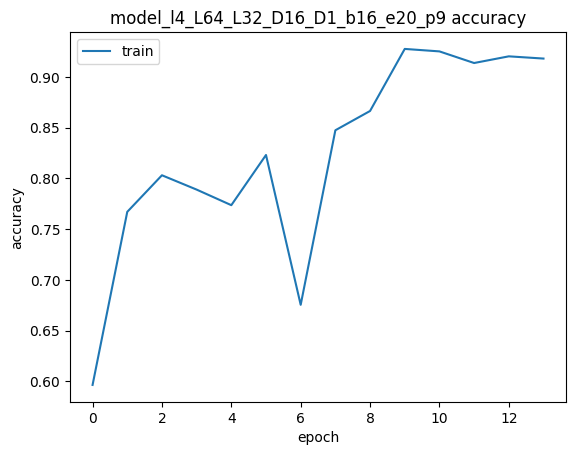

In [80]:
evaluation = model.evaluate(X_test,y_test,verbose=True,return_dict=True)
print(evaluation)
np.save(f"{history_name}.npy",history.history)
history.history
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title(f'{model_name} accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"{history_name}.png")
plt.show()

29/29 [==============================] - 2s 51ms/step


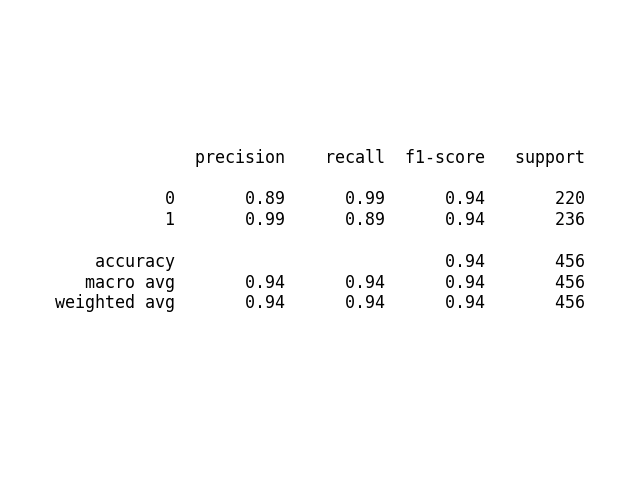

In [81]:
y_pred = model.predict(X_test, batch_size=16, verbose=1)
y_pred = y_pred>0.5
report = classification_report(y_test, y_pred) 
# Create a figure and axis to plot the text
fig, ax = plt.subplots(figsize=(8, 6)) # Adjust the size as needed
ax.text(0.5, 0.5, report, horizontalalignment='center', verticalalignment='center', 
        fontsize=12, family='monospace', transform=ax.transAxes)
ax.axis('off')

# Save to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

# Display the image in the notebook
display(Image(buf.getvalue()))

# Optionally, write to a file
with open(f'{model_name}_conf.png', 'wb') as f:
    f.write(buf.getvalue())

plt.close(fig)

In [82]:
model.save(f"{model_name}.h5",save_format="h5")

In [83]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert() 
# Save the model.
with open(f'{model_name}.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\prach\AppData\Local\Temp\tmp9awpazkj\assets


INFO:tensorflow:Assets written to: C:\Users\prach\AppData\Local\Temp\tmp9awpazkj\assets
